In [1]:
import pandas as pd
import spacy
from torchtext.data import Field, TabularDataset

In [2]:
dfs = {}
for mode in ['train','test']:
    dfs[mode] = pd.read_csv('data/imdb/aclImdb/{}.txt'.format(mode),header=None)
    dfs[mode].columns = ['fn']
    dfs[mode]['lab'] = dfs[mode]['fn'].apply(lambda x: x.split('/')[1])
    dfs[mode]['rev'] = dfs[mode]['fn'].apply(lambda x: '\n'.join(open('data/imdb/aclImdb/'+x).readlines()))
    dfs[mode]['is_valid'] = dfs[mode].apply(lambda x: mode == 'test',axis=1)
    dfs[mode] = dfs[mode].sample(frac=0.1)
    dfs[mode].to_csv(mode+'df.csv',index=False)

In [3]:
len(dfs['train'])

2500

In [4]:
!pwd

/home/ibis/learning/fastai-nlp


In [5]:
import re  
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        # remove punctuation
        text = re.sub('[^a-zA-Z0-9]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        cleaned_text.append(text)
    return cleaned_text


In [6]:
TEXT = Field(sequential=True,preprocessing=cleanup_text,lower=True)
LABEL = Field(sequential=False, use_vocab=True)
datflds = [("fn",None),("lab",LABEL),("rev",TEXT),("is_valid",None)]
trn,val = TabularDataset.splits(path='',train='traindf.csv',validation='testdf.csv',format='csv',skip_header=True, fields=datflds)

In [7]:
len(vars(trn)['examples'])

2500

In [8]:
TEXT.build_vocab(trn,min_freq=2,max_size=5000)
LABEL.build_vocab(trn)

In [9]:
len(TEXT.vocab.freqs.keys())

48431

In [10]:
len(TEXT.vocab.itos),len(TEXT.vocab.stoi)

(5002, 5002)

In [11]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(TEXT.vocab.stoi[word])

0
0
0
0
0
0


In [12]:
' '.join([TEXT.vocab.itos[TEXT.vocab.stoi[x]] for x in trn[0].rev])

'<unk> <unk> one of the most <unk> and grand directors we <unk> <unk> have  is not yet available on dvd   it s summer <unk> right now  mysteries to <unk> the mind   br  br  this grand classic returned to the theaters in my <unk> thanks to a <unk> <unk>   <unk> and to see it again on the big screen after all these years of viewing it on a <unk>   it is a true <unk>  br  br  to avoid a <unk> but nonetheless try to prove a point  i took my reluctant younger brother with me to see this film  he never saw the film before and <unk> like those italian <unk> like all the others in the theater he was <unk> by this wonder  even during the <unk> the theater <unk> completely <unk>  br  br  this special day is truly special  a wonder of <unk> and a big loss if you haven t seen it <unk>'

In [13]:
df=pd.concat([dfs['train'],dfs['test']])

In [14]:
from collections import Counter
make_token_counter = lambda x: Counter([TEXT.vocab.stoi[i] for i in trn[x].rev])

In [15]:
make_token_counter(0).items()

dict_items([(0, 22), (31, 1), (5, 3), (2, 9), (82, 1), (3, 4), (1813, 2), (930, 1), (73, 1), (1596, 1), (7, 3), (23, 1), (252, 1), (1370, 1), (19, 3), (1132, 1), (565, 1), (2274, 1), (268, 1), (508, 1), (4728, 1), (6, 6), (987, 1), (13, 6), (226, 2), (374, 1), (3099, 1), (4418, 1), (8, 2), (61, 2), (1254, 1), (4, 7), (29, 2), (69, 2), (12, 4), (302, 1), (177, 2), (393, 1), (100, 1), (36, 2), (118, 1), (160, 1), (1230, 1), (339, 1), (927, 1), (740, 1), (18, 1), (4318, 1), (352, 1), (2259, 1), (854, 1), (9, 1), (488, 1), (4780, 1), (1581, 1), (905, 1), (17, 1), (94, 1), (10, 2), (71, 1), (28, 2), (102, 1), (186, 1), (26, 1), (163, 1), (38, 2), (142, 1), (1470, 1), (555, 1), (994, 2), (14, 1), (32, 1), (4884, 1), (57, 1), (275, 1), (281, 1), (313, 1), (417, 1), (314, 1), (2182, 1), (564, 1), (2796, 1), (45, 1), (22, 1), (715, 1), (116, 1)])

In [16]:
import numpy as np
n_terms = len(TEXT.vocab.itos)
n_docs = len(trn)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = make_token_counter):
    embedding = np.zeros(n_terms)
    counter = make_token_counter(review_index)
    embedding[list(counter.keys())] = list(counter.values())
    return embedding

In [17]:
embedding = count_vectorizer(0)

In [19]:
import pdb
def make_term_doc_matrix(n_docs):
    for i in range(n_docs):
        #pdb.set_trace()
        emb = count_vectorizer(i)
        if i == 0:
            tdm = emb
        else:
            tdm = np.vstack((tdm,emb))
    return tdm

In [20]:
mat = make_term_doc_matrix(n_docs)

In [21]:
mat.shape

(2500, 5002)

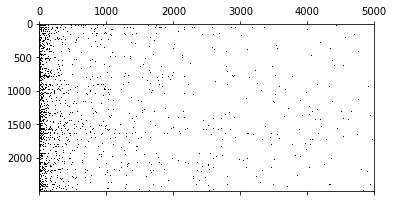

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.spy(mat)

In [37]:
nlp = spacy.load("en")

In [28]:
t=nlp(df['rev'].iloc[0])

In [24]:
df['rev'].iloc[0]

"Esther Williams gets her first post MGM starring role and gets off<br /><br />to a good start. This film is a well acted entertaining suspense<br /><br />with a mature theme that would be repeated a million times more<br /><br />in the future - innocent girl stalked creepy woman hater. Esther<br /><br />looks great and if she wanted to, probably could have gone on to<br /><br />do more and better films but according to her autobiography, <br /><br />pretty much gave up working for marriage. Either way she is so<br /><br />likable and engaging that its fun to see her in a totally different role<br /><br />outside of the 'swimming musical'. Universal was fabulous for<br /><br />making films with former MGM stars after that studio began<br /><br />dropping its biggest names as it began to slide down hill. Stars<br /><br />like Lana Turner, June Allyson and others got to make quality first<br /><br />rate films at Universal as they obviously still had drawing power at<br /><br />the box o

In [29]:
[x.text for x in t]

['Esther',
 'Williams',
 'gets',
 'her',
 'first',
 'post',
 'MGM',
 'starring',
 'role',
 'and',
 'gets',
 'off',
 '<',
 'br',
 '/><br',
 '/>to',
 'a',
 'good',
 'start',
 '.',
 'This',
 'film',
 'is',
 'a',
 'well',
 'acted',
 'entertaining',
 'suspense',
 '<',
 'br',
 '/><br',
 '/>with',
 'a',
 'mature',
 'theme',
 'that',
 'would',
 'be',
 'repeated',
 'a',
 'million',
 'times',
 'more',
 '<',
 'br',
 '/><br',
 '/>in',
 'the',
 'future',
 '-',
 'innocent',
 'girl',
 'stalked',
 'creepy',
 'woman',
 'hater',
 '.',
 'Esther',
 '<',
 'br',
 '/><br',
 '/>looks',
 'great',
 'and',
 'if',
 'she',
 'wanted',
 'to',
 ',',
 'probably',
 'could',
 'have',
 'gone',
 'on',
 'to',
 '<',
 'br',
 '/><br',
 '/>do',
 'more',
 'and',
 'better',
 'films',
 'but',
 'according',
 'to',
 'her',
 'autobiography',
 ',',
 '<',
 'br',
 '/><br',
 '/>pretty',
 'much',
 'gave',
 'up',
 'working',
 'for',
 'marriage',
 '.',
 'Either',
 'way',
 'she',
 'is',
 'so',
 '<',
 'br',
 '/><br',
 '/>likable',
 'and',
 '